# The Missing Data Gap

In data-driven prognostics, missing data is often cleaned before training. This leaves the question of what to do when we apply these models in the real world and observe msising data. In this notebook, we demonstrate the "gap" in performance when data is missing in a state-of-the-art model trained on only clean data (the first sub-dataset in the N-CMAPSS dataset).

In [21]:
import torch
import torch.nn as nn
torch.multiprocessing.set_sharing_strategy('file_system')
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import DataUtils
import Masking

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data Loading

In [23]:
batch_size = 64
trainloader, testloader = DataUtils.get_ncmapss_dataloaders(1, n_timesteps=10, batch=batch_size, workers=8, subsampled=True)

## Defining an RUL Transformer Model

In [24]:
class RULTransformer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.prediction_window = 1 # only estimates the next point
        self.input_len = 10 # timesteps of 10
        self.n_cols = 35 # 46 columns present in the data
        self.embed_dim = 64 # project to a 64-dimensional space
        
        self.input_projection = nn.Linear(self.input_len*self.n_cols, self.embed_dim) 
        self.positional_embed = nn.Parameter(torch.randn(self.embed_dim)) # learned positional embeddings
        
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=self.embed_dim, nhead=4, activation="gelu", dim_feedforward=64)
        self.transformer_blocks = nn.TransformerEncoder(self.encoder_layer, num_layers=1)
        
        self.rul_head = nn.Sequential(nn.Linear(self.embed_dim, self.prediction_window)) # linear rul prediction head 
    
    def forward(self, x):
        x = x.flatten(1)
        z = self.input_projection(x)
        z = z + self.positional_embed
        z = self.transformer_blocks(z)
        z = self.rul_head(z)
        
        return z.squeeze(1)

## Training on Clean Data

In [25]:
objective = nn.MSELoss()

rul_tran = RULTransformer().to(device)

columns_kept = [True, True, True, True,
               True, True, True, True, True, True, True, True, True, True, True, True, True, True,
               True, True, True, True, True, True, True, True, True, True, True, True, True, True,
               False, False, False, False, False, False, False, False, False, False,
               True, True, True, False]

lr = 1e-4
n_epochs = 5
optim = torch.optim.Adam(rul_tran.parameters(), lr=lr)
losses = []

for n in range(n_epochs):
    counter = 0
    for i, (X, y) in enumerate(tqdm(trainloader)):
        X = X.to(device)[:, :, columns_kept]
        y = y.to(device)
        optim.zero_grad()
        yhat = rul_tran(X.float())
        loss = objective(yhat, y.float().squeeze(1))
        loss.backward()
        losses.append(loss.cpu().detach().numpy())
        optim.step()
        counter += 1
        
    print("Epoch:", n+1, "Loss:",np.mean(losses[-counter:][0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:06<00:00, 114.64it/s]


Epoch: 1 Loss: 3015.77


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:05<00:00, 117.48it/s]


Epoch: 2 Loss: 10.416317


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:05<00:00, 117.39it/s]


Epoch: 3 Loss: 0.840093


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:05<00:00, 117.43it/s]


Epoch: 4 Loss: 0.24950403


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7667/7667 [01:05<00:00, 116.65it/s]

Epoch: 5 Loss: 0.27318478


In [26]:
test_mses = []
yhats = []
ys = []
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(testloader)):
        yhat = rul_tran(X.float().to(device)[:, :, columns_kept])
        yhats.append(yhat.cpu())
        ys.append(y.cpu())
        test_mse = objective(yhat, y.float().to(device))
        test_mses.append(test_mse.item())
print("Test MSE:", np.mean(test_mses))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4274/4274 [00:36<00:00, 117.95it/s]

Test MSE: 11.554925272327525


In [27]:
print("Test RMSE: {}".format(np.sqrt(np.mean(test_mses))))

Test RMSE: 3.3992536345979723


With clean test data, a model without tuned hyperparameters can achieve the above RMSE

## Injecting Missing Data

In [28]:
test_mses_missing = []
yhats_missing = []
ys_missing = []
with torch.no_grad():
    for i, (X, y) in enumerate(tqdm(testloader)):
        masked_X = Masking.mask_input(X[:, :, columns_kept])
        yhat = rul_tran(masked_X.float().to(device))
        yhats_missing.append(yhat.cpu())
        ys_missing.append(y.cpu())
        test_mse = objective(yhat, y.float().to(device))
        test_mses_missing.append(test_mse.item())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4274/4274 [00:40<00:00, 105.02it/s]


In [29]:
print("Test MSE:", np.mean(test_mses_missing))
print("Test RMSE: {}".format(np.sqrt(np.mean(test_mses_missing))))

Test MSE: 645.4634139257778
Test RMSE: 25.40597201300863


The performance on missing data is much worse! There is a huge gap that needs to be addressed.

## Plotting the Gap

In [30]:
# Function to find the indices to split the plots
def find_splits(y_data):
    splits = [0]
    for i in range(1, len(y_data)):
        if y_data[i-1] == 0 and y_data[i] != 0:
            splits.append(i)
            
    splits.append(len(y_data))
    return splits

yhats = torch.cat(yhats)
yhats_missing = torch.cat(yhats_missing)
ys = torch.cat(ys)
split_idx = find_splits(ys)

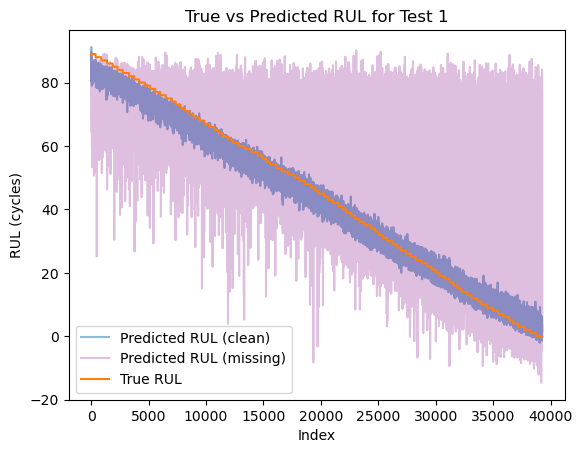

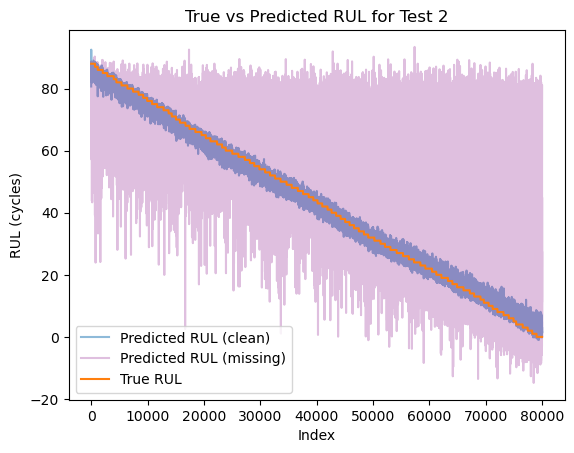

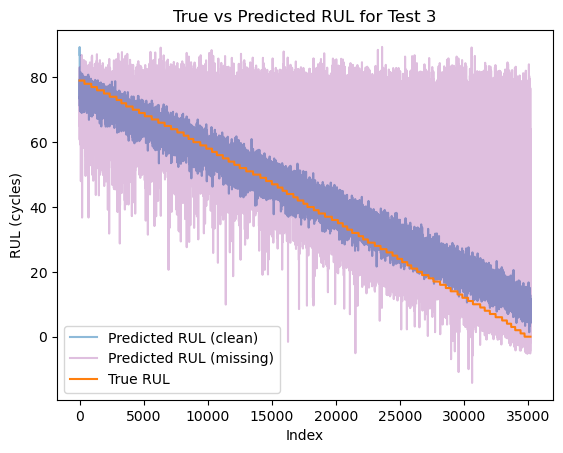

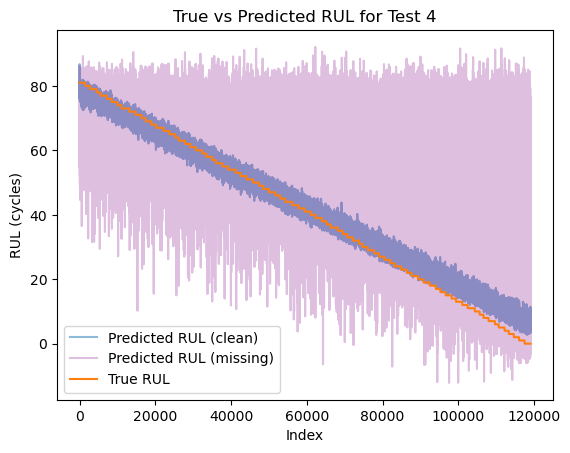

In [31]:
for i in range(len(split_idx)-1):
    num_pts = len(ys[split_idx[i]:split_idx[i+1]])
    plt.title("True vs Predicted RUL for Test " + str(i+1))
    plt.plot(range(num_pts), yhats[split_idx[i]:split_idx[i+1]], alpha=0.5, label='Predicted RUL (clean)')
    plt.plot(range(num_pts), yhats_missing[split_idx[i]:split_idx[i+1]], alpha=0.25, label='Predicted RUL (missing)', color='purple' )
    plt.plot(ys[split_idx[i]:split_idx[i+1]], label='True RUL')
    plt.xlabel("Index")
    plt.ylabel("RUL (cycles)")
    plt.legend()
    plt.show()